# import modules

In [1]:
import sys

sys.path.insert(0, "../")

from modules.Classes_ver2 import *
from modules.default_params_ver1 import *
from modules.functions_ver2 import *
from multiprocessing import Pool, cpu_count

print("Number of cores: ", cpu_count())

Number of cores:  8


# assign params

In [2]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

# mismatch optimized over $\tilde{\theta}$, $\tilde{\Omega}$, and $\gamma_P$

In [32]:
def compute_mismatch(r, c, tpl_params, src_params, opt_match):
    n_pts = 5
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    tpl_params["omega_tilde"] = X[r, c]
    tpl_params["theta_tilde"] = Y[r, c]

    optimized_mismatch_results_dict = optimize_mismatch_gammaP(
        tpl_params, src_params, use_opt_match=opt_match
    )

    return (
        optimized_mismatch_results_dict["ep_min"],
        optimized_mismatch_results_dict["ep_min_gammaP"],
    )


def get_error_bars(X, Y, Z, min_idx, thres_factor=1.1):
    Z_threshold = Z[min_idx] * thres_factor
    indices = np.where(Z < Z_threshold)
    X_vals = X[indices]
    Y_vals = Y[indices]
    return X_vals, Y_vals


def mismatch_contour_parallel(tpl_params, src_params, opt_match=True):
    n_pts = 5
    omega_tilde_arr = np.linspace(0, 3, n_pts)
    theta_tilde_arr = np.linspace(0, 8, n_pts)
    X, Y = np.meshgrid(omega_tilde_arr, theta_tilde_arr)
    Z = np.zeros_like(X)
    g_min_matrix = np.zeros_like(X)

    # Create a pool of worker processes
    with Pool(cpu_count()) as pool:  # Use maximum number of cores
        results = []
        for r in range(n_pts):
            for c in range(n_pts):
                results.append(
                    pool.apply_async(
                        compute_mismatch, args=(r, c, tpl_params, src_params, opt_match)
                    )
                )

        for r in range(n_pts):
            for c in range(n_pts):
                idx = r * n_pts + c
                Z[r, c], g_min_matrix[r, c] = results[idx].get()

    min_idx = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
    max_idx = np.unravel_index(np.argmax(Z, axis=None), Z.shape)

    X_err, Y_err = get_error_bars(X, Y, Z, min_idx)

    results_dict = {
        "ep_0_0": Z[0, 0],
        "ep_min": Z[min_idx],
        "ep_min_omega_tilde": X[min_idx],
        "ep_min_theta_tilde": Y[min_idx],
        "ep_min_gammaP": g_min_matrix[min_idx],
        "ep_max": Z[max_idx],
        "ep_max_omega_tilde": X[max_idx],
        "ep_max_theta_tilde": Y[max_idx],
        "ep_max_gammaP": g_min_matrix[max_idx],
        "ep_max_min_ratio": Z[max_idx] / Z[min_idx],
        "omega_tilde_err": X_err,
        "theta_tilde_err": Y_err,
    }

    return results_dict

# as a function of $\Delta t_d$ while fixing $I$

In [ ]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

RP_params["omega_tilde"] = 3.0
MLz_limits = get_lens_limits_for_RP_L(RP_params, lens_params["y"])
print(MLz_limits)

In [33]:
I = LensingGeo(lens_params).I()
MLz_arr = np.linspace(
    math.floor(MLz_limits["MLz_min"]), math.ceil(MLz_limits["MLz_max"]), 25
)
td_arr = np.zeros_like(MLz_arr)

mismatch_td_dict = {}

for i, MLz in enumerate(MLz_arr):
    lens_params["MLz"] = MLz * solar_mass
    td = LensingGeo(lens_params).td()
    td_arr[i] = td
    mismatch_td_dict[td] = mismatch_contour_parallel(RP_params, lens_params)

In [34]:
now = datetime.now()
filename = "mismatch_td_dict_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".pkl"
filepath = os.path.join("data", filename)
with open(filepath, "wb") as f:
    pickle.dump(mismatch_td_dict, f)
    print("Results saved as", filepath)

Results saved as data/mismatch_Deltatd_dict_2024-04-22_20-20-08.pkl


In [35]:
with open(filepath, "rb") as f:
    mismatch_td_dict = pickle.load(f)

mismatch_td_dict

{0.003980865926558968: {'ep_0_0': 0.00041228706273599425,
  'ep_min': 0.0003878530133807345,
  'ep_min_omega_tilde': 0.0,
  'ep_min_theta_tilde': 4.0,
  'ep_min_gammaP': 2.792526803190927,
  'ep_max': 0.16620879241326003,
  'ep_max_omega_tilde': 3.0,
  'ep_max_theta_tilde': 8.0,
  'ep_max_gammaP': 2.221328138901874,
  'ep_max_min_ratio': 428.53551907330876,
  'omega_tilde_err': array([0.  , 0.75, 1.5 , 2.25, 3.  , 0.  , 0.  , 0.  ]),
  'theta_tilde_err': array([0., 0., 0., 0., 0., 2., 4., 6.])},
 0.005466693676236167: {'ep_0_0': 0.005752408149732546,
  'ep_min': 0.0016613545519535977,
  'ep_min_omega_tilde': 0.0,
  'ep_min_theta_tilde': 8.0,
  'ep_min_gammaP': 3.3002589492256416,
  'ep_max': 0.17197227031288165,
  'ep_max_omega_tilde': 3.0,
  'ep_max_theta_tilde': 8.0,
  'ep_max_gammaP': 2.3482611754105527,
  'ep_max_min_ratio': 103.51328686020592,
  'omega_tilde_err': array([0.]),
  'theta_tilde_err': array([8.])},
 0.006952521425913366: {'ep_0_0': 0.03854932249797083,
  'ep_min': 0.0

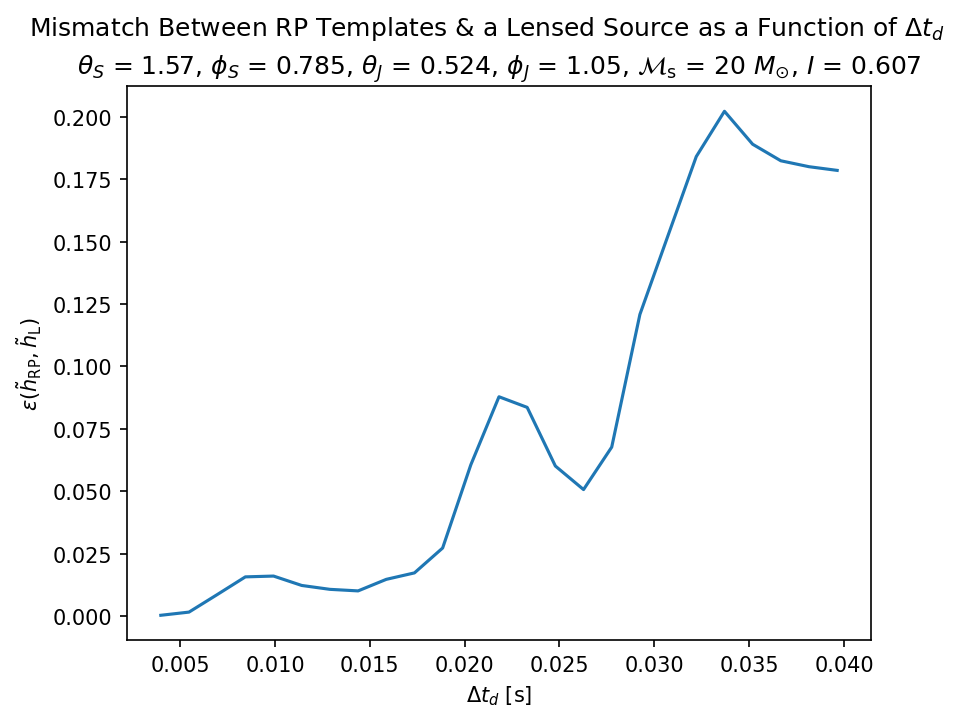

In [36]:
td_ep_min_arr = np.array([mismatch_td_dict[td]["ep_min"] for td in td_arr])

plt.plot(td_arr, td_ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
plt.xlabel(r"$\Delta t_d$ [s]")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source as a Function of $\Delta t_d$"
)

plt.show()

In [37]:
td_ep_min_omega_tilde_arr = np.array(
    [mismatch_td_dict[td]["ep_min_omega_tilde"] for td in td_arr]
)
lower_omega_tilde_err = td_ep_min_omega_tilde_arr - np.array(
    [np.min(mismatch_td_dict[td]["omega_tilde_err"]) for td in td_arr]
)
upper_omega_tilde_err = (
    np.array([np.max(mismatch_td_dict[td]["omega_tilde_err"]) for td in td_arr])
    - td_ep_min_omega_tilde_arr
)
asym_omega_tilde_err = [lower_omega_tilde_err, upper_omega_tilde_err]

print(asym_omega_tilde_err)

[array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.5 , 0.  , 0.  , 3.  , 3.  ,
       1.5 , 3.  , 2.25]), array([3. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1.5, 0. , 0. ])]


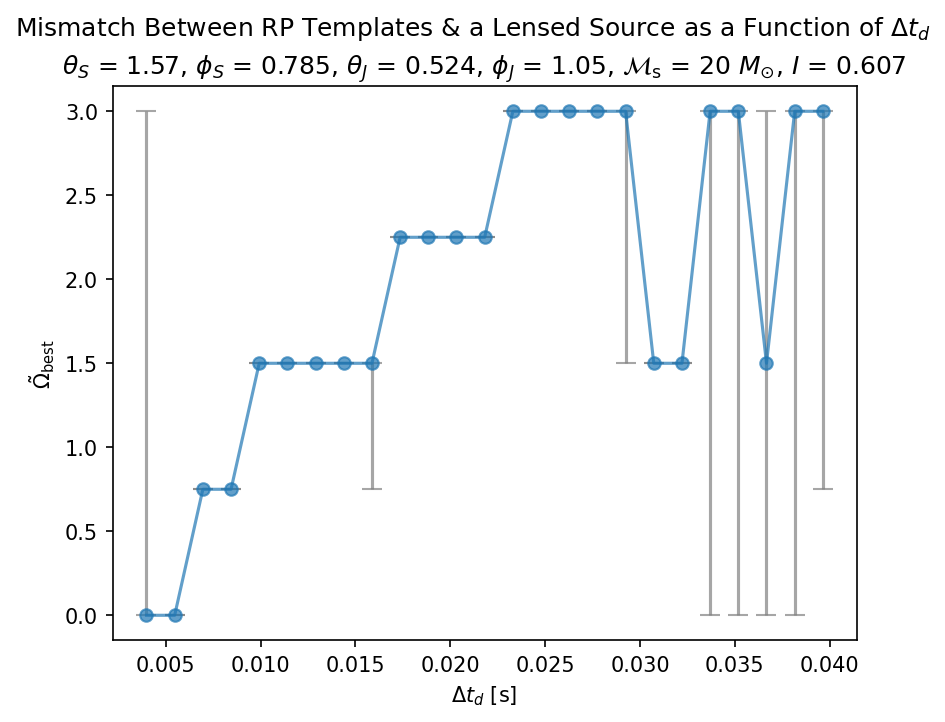

In [42]:
# plt.plot(td_arr, td_ep_min_omega_tilde_arr, label=r"$\~{\Omega}_{\rm best}$")
plt.errorbar(
    td_arr,
    td_ep_min_omega_tilde_arr,
    yerr=asym_omega_tilde_err,
    fmt="-o",
    label=r"$\~{\Omega}_{\rm best}$",
    capsize=5,
    ecolor="grey",
    alpha=0.7,
)
plt.xlabel(r"$\Delta t_d$ [s]")
plt.ylabel(r"$\~{\Omega}_{\rm best}$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $I$ = {:.3g}".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        I,
    )
)

plt.suptitle(
    r"Mismatch Between RP Templates & a Lensed Source as a Function of $\Delta t_d$"
)

plt.show()

# as a function of $I$ while fixing $\Delta t_d$

In [47]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

# create y_range and MLz_range based on the same time delay
y_arr = np.linspace(0.5, 3, 25)[::-1]
td = 0.1
MLz_arr = get_MLz_from_td(td, y_arr)
print(MLz_arr)
I_arr = np.zeros_like(MLz_arr)

mismatch_I_dict = {}

for i in range(len(y_arr)):
    lens_params["y"] = y_arr[i]
    lens_params["MLz"] = MLz_arr[i] * solar_mass
    I = LensingGeo(lens_params).I()
    I_arr[i] = I
    mismatch_I_dict[I] = mismatch_contour_parallel(RP_params, lens_params)

[ 650.80264919  683.32015779  718.34912092  756.16844215  797.10002652
  841.51763732  889.8580822   942.63548085 1000.45965705 1064.06012115
 1134.31773399 1212.30708622 1299.35407312 1397.11541645 1507.69053651
 1633.78221032 1778.93272511 1947.88034317 2147.11408746 2385.7685298
 2677.1290506  3041.29541964 3510.19604243 4137.78978207 5023.02038887]


In [44]:
now = datetime.now()
filename = "mismatch_I_dict_" + now.strftime("%Y-%m-%d_%H-%M-%S") + ".pkl"
filepath = os.path.join("data", filename)
with open(filepath, "wb") as f:
    pickle.dump(mismatch_I_dict, f)
    print("Results saved as", filepath)

Results saved as data/mismatch_I_dict_2024-04-22_20-26-00.pkl


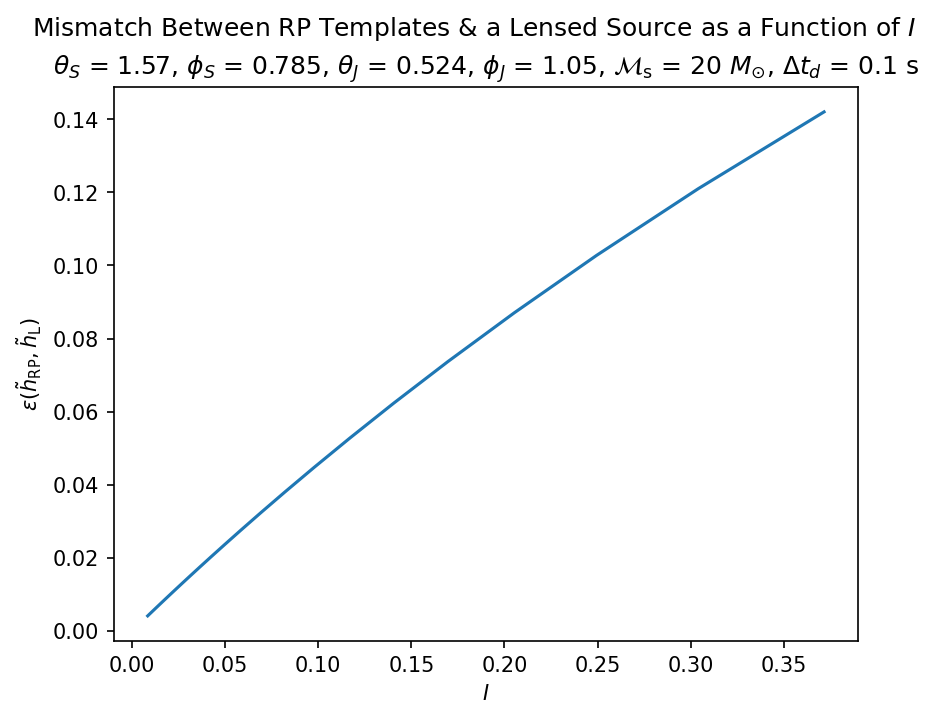

In [49]:
I_ep_min_arr = np.array([mismatch_I_dict[I]["ep_min"] for I in I_arr])

plt.plot(I_arr, I_ep_min_arr, label=r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")
plt.xlabel(r"$I$")
plt.ylabel(r"$\epsilon(\~h_{\rm RP}, \~h_{\rm L})$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} s".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        td,
    )
)

plt.suptitle(r"Mismatch Between RP Templates & a Lensed Source as a Function of $I$")

plt.show()

In [50]:
I_ep_min_theta_tilde_arr = np.array(
    [mismatch_I_dict[I]["ep_min_theta_tilde"] for I in I_arr]
)
lower_theta_tilde_err = I_ep_min_theta_tilde_arr - np.array(
    [np.min(mismatch_I_dict[I]["theta_tilde_err"]) for I in I_arr]
)
upper_theta_tilde_err = (
    np.array([np.max(mismatch_I_dict[I]["theta_tilde_err"]) for I in I_arr])
    - I_ep_min_theta_tilde_arr
)
asym_theta_tilde_err = [lower_theta_tilde_err, upper_theta_tilde_err]

print(asym_theta_tilde_err)

[array([0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 4., 6., 6., 6.]), array([8., 8., 8., 8., 8., 8., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 4., 2., 2., 2.])]


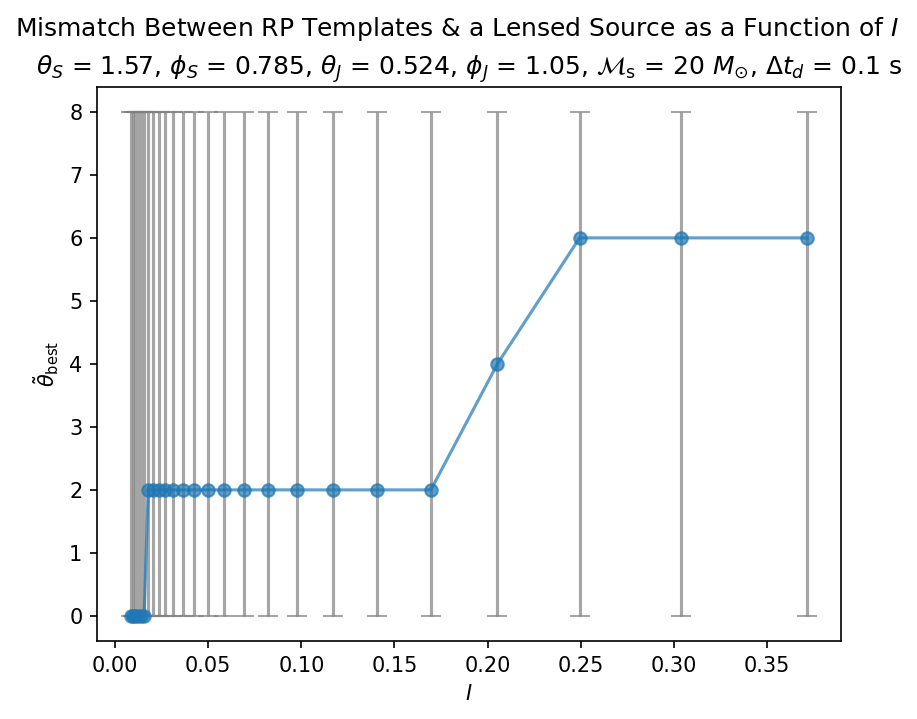

In [51]:
# plt.plot(I_arr, I_ep_min_theta_tilde_arr, label=r"$\~{\theta}_{\rm best}$")
plt.errorbar(
    I_arr,
    I_ep_min_theta_tilde_arr,
    yerr=asym_theta_tilde_err,
    fmt="-o",
    label=r"$\~{\theta}_{\rm best}$",
    capsize=5,
    ecolor="grey",
    alpha=0.7,
)
plt.xlabel(r"$I$")
plt.ylabel(r"$\~{\theta}_{\rm best}$")

plt.title(
    r"$\theta_S$ = {:.3g}, $\phi_S$ = {:.3g}, $\theta_J$ = {:.3g}, $\phi_J$ = {:.3g}, {} = {:.3g} {}, $\Delta t_d$ = {:.3g} s".format(
        lens_params["theta_S"],
        lens_params["phi_S"],
        lens_params["theta_J"],
        lens_params["phi_J"],
        r"$\mathcal{M}_{\text{s}}$",
        lens_params["mcz"] / solar_mass,
        r"$M_{\odot}$",
        td,
    )
)

plt.suptitle(r"Mismatch Between RP Templates & a Lensed Source as a Function of $I$")

plt.show()

# waveform comparison

In [ ]:
lens_params, RP_params, NP_params = set_to_params(
    lens_params_1, RP_params_1, NP_params_1
)

MLz_arr = np.linspace(400, 4600, 30)
td_ep_min_arr = np.array([mismatch_td_dict[td]["ep_min"] for td in td_arr])

for i in range(len(MLz_arr)):
    lens_params, RP_params = set_to_params(lens_params_1, RP_params_1)
    lens_params["MLz"] = MLz_arr[i] * solar_mass
    RP_params["omega_tilde"] = mismatch_td_dict[td_arr[i]]["ep_min_omega_tilde"]
    RP_params["theta_tilde"] = mismatch_td_dict[td_arr[i]]["ep_min_theta_tilde"]
    RP_params["gamma_P"] = mismatch_td_dict[td_arr[i]]["ep_min_gammaP"]

    plot_waveform_comparison(RP_params, lens_params)
    plt.show()